In [1]:
from sklearn.cluster import MiniBatchKMeans
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import models
from torchinfo import summary
from IPython.display import clear_output
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

#from funcs import get_cifar10_mu_std_img, normalize
from resnet import *

In [2]:
device = torch.device("cuda")

In [3]:
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Files already downloaded and verified


In [4]:
BATCH_SIZE = 100
loader_test = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
from resnet import resnet50

model = resnet50(pretrained=True)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
features = {}
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()

    return hook

In [7]:
model.layer4.register_forward_hook(get_features('last_conv'))
model.avgpool.register_forward_hook(get_features('last_fc'))

In [8]:
num_test_samples = len(test_data)

last_conv_feats, last_fc_feats = [], []
x_test, y_test = [], []

# placeholder for batch features
features = {}

# loop through batches
for idx, batch in enumerate(loader_test):
    x = batch[0]
    y = batch[1]
    x_test.append(x)
    y_test.append(y)

    x = x.to(device)
    # forward pass [with feature extraction]
    preds = model(x)

    # add feats and preds to lists
    last_conv_feats.append(features['last_conv'].cpu().numpy())
    last_fc_feats.append(features['last_fc'].cpu().numpy())

    print('Finished', idx, 'batches...')
    clear_output(wait=True)

Finished 99 batches...


In [9]:
x_test_np = [tensor.numpy() for tensor in x_test]
y_test_np = [tensor.numpy() for tensor in y_test]

raw_pixel_feats = np.array(x_test_np).reshape(num_test_samples, -1)
labels = np.array(y_test_np).reshape(num_test_samples, )
conv_feats = np.array(last_conv_feats).reshape(num_test_samples, -1)
fc_feats = np.array(last_fc_feats).reshape(num_test_samples, -1)

## Pairwise distances

In [24]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(raw_pixel_feats)
D.shape

%matplotlib inline
import matplotlib.pyplot as plt

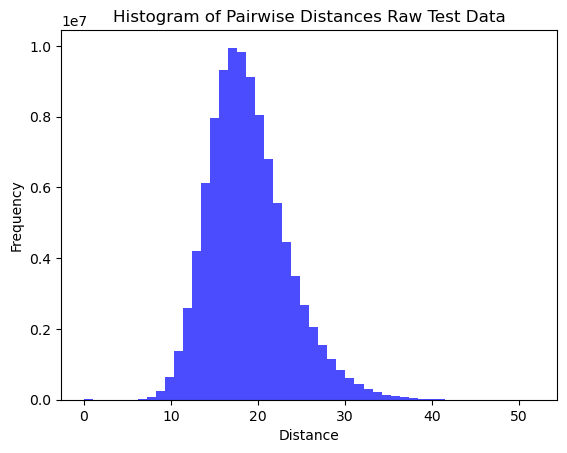

In [25]:
distances = D.flatten()

# Step 3: Plot the histogram
plt.hist(distances, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Pairwise Distances Raw Test Data')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()

In [26]:
from sklearn.metrics import pairwise_distances
D_last_conv_test = pairwise_distances(conv_feats)
D_last_conv_test.shape

(10000, 10000)

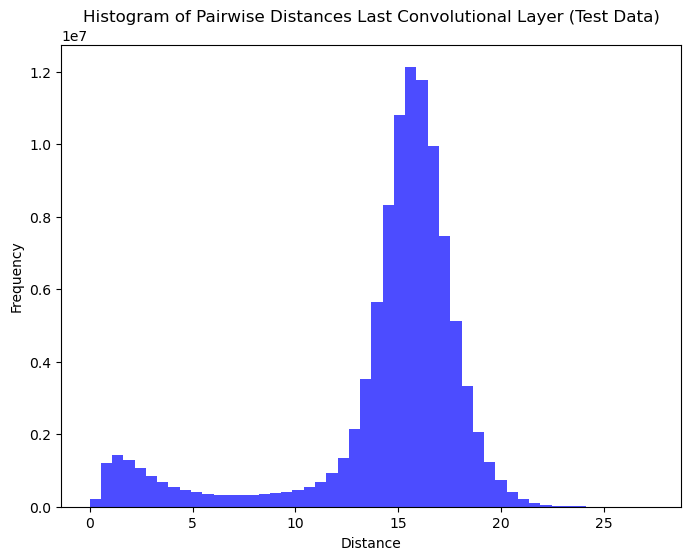

In [27]:
distances = D_last_conv_test.flatten()
plt.figure(figsize=(8, 6))
# Step 3: Plot the histogram
plt.hist(distances, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Pairwise Distances Last Convolutional Layer (Test Data)')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()

In [28]:
from sklearn.metrics import pairwise_distances
D_last_fc_test = pairwise_distances(fc_feats)
D_last_fc_test.shape

(10000, 10000)

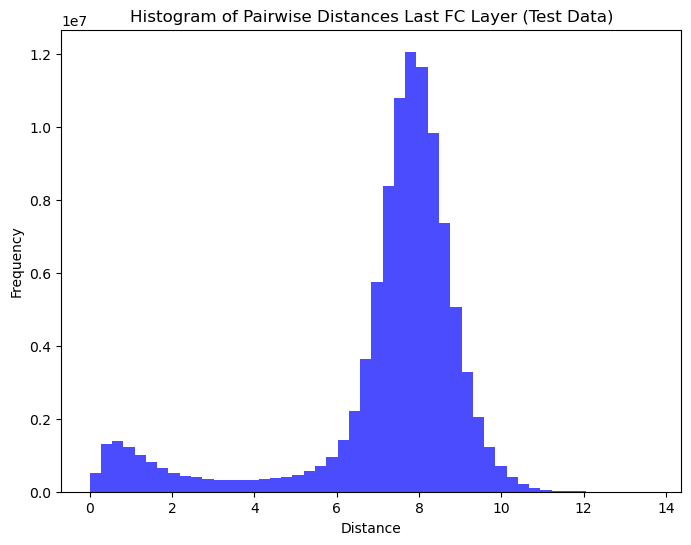

In [29]:
distances = D_last_fc_test.flatten()
plt.figure(figsize=(8, 6))
# Step 3: Plot the histogram
plt.hist(distances, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Pairwise Distances Last FC Layer (Test Data)')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()

## Clusters

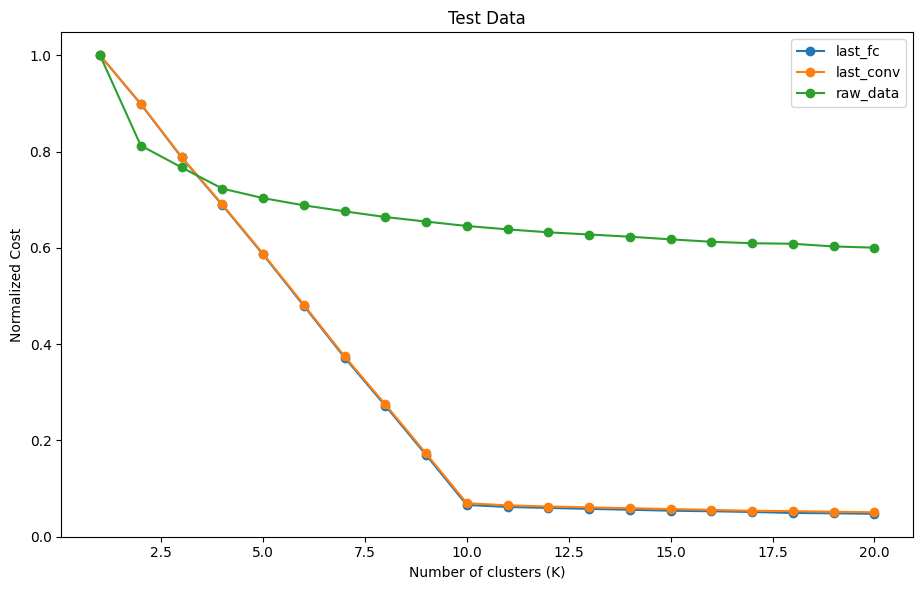

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import MinMaxScaler

# Function to compute K-means for a given feature set (train or test)
def compute_kmeans(features):
    costs = []
    for k in range(1, 21):
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
        kmeans.fit(features)
        costs.append(kmeans.inertia_)
    # Normalize costs by dividing by the cost when k=1
    costs_normalized = np.array(costs) / costs[0]
    return costs_normalized

# Compute K-means costs for last_fc features
last_fc_test_costs = compute_kmeans(fc_feats)

# Compute K-means costs for last_conv features
last_conv_test_costs = compute_kmeans(conv_feats)

# Compute K-means costs for raw data
x_test_costs = compute_kmeans(raw_pixel_feats)

# Plotting
plt.figure(figsize=(18, 6))

# Plot for test data
plt.subplot(1, 2, 2)
plt.plot(range(1, 21), last_fc_test_costs, marker='o', label='last_fc')
plt.plot(range(1, 21), last_conv_test_costs, marker='o', label='last_conv')
plt.plot(range(1, 21), x_test_costs, marker='o', label='raw_data')
plt.title('Test Data')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Normalized Cost')
plt.legend()

plt.tight_layout()
plt.show()

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import MinMaxScaler

# Function to compute K-means for a given feature set (train or test)
def compute_kmeans(features):
    costs = []
    for k in range(1, 21):
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
        kmeans.fit(features)
        costs.append(kmeans.inertia_)
    # Normalize costs by dividing by the cost when k=1
    costs_normalized = np.array(costs) / costs[0]
    return costs_normalized

# Compute K-means costs for last_fc features
last_fc_test_costs = compute_kmeans(fc_feats)

# Compute K-means costs for last_conv features
last_conv_test_costs = compute_kmeans(conv_feats)

# Compute K-means costs for raw data
x_test_costs = compute_kmeans(x_test_np.reshape(x_test.shape[0], -1))

# Plotting
plt.figure(figsize=(18, 6))


# Plot for test data
plt.plot(range(1, 21), last_fc_test_costs, marker='o', label='last_fc')
plt.plot(range(1, 21), last_conv_test_costs, marker='o', label='last_conv')
plt.plot(range(1, 21), x_test_costs, marker='o', label='raw_data')
plt.title('Test Data')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Normalized Cost')
plt.legend()

plt.tight_layout()
plt.show()


c:\Users\Jeremiah\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
c:\Users\Jeremiah\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1962: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
c:\Users\Jeremiah\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
c:\Users\Jeremiah\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1962: UserWarning: MiniBatchKMeans is kno

AttributeError: 'list' object has no attribute 'reshape'

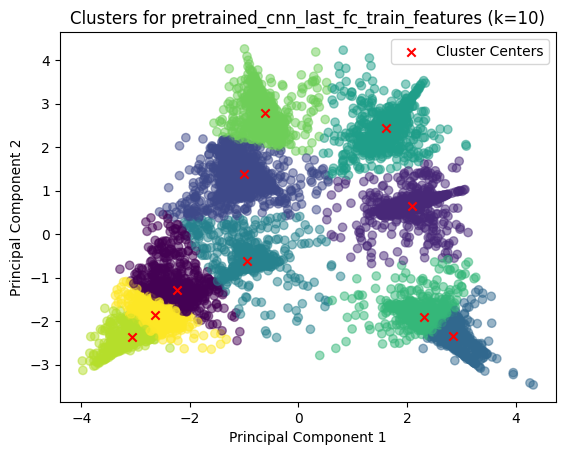

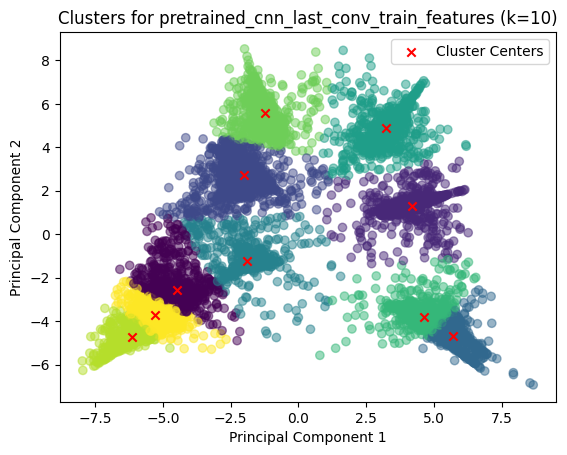

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Function to compute K-means for a given feature set (train or test)
def compute_kmeans(features, n_clusters=10):
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features)
    return kmeans.labels_, kmeans.cluster_centers_

# Function to visualize clusters
def plot_clusters(features, labels, centers, title):
    plt.scatter(features[:, 0], features[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.scatter(centers[:, 0], centers[:, 1], marker='x', c='red', label='Cluster Centers')
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

# Assuming pretrained_cnn_last_fc_train_features and pretrained_cnn_last_conv_train_features are defined

# Perform PCA for pretrained_cnn_last_fc_train_features
pca_fc = PCA(n_components=2)
pca_fc.fit(fc_feats)
last_fc_train_pca = pca_fc.transform(fc_feats)

# Perform PCA for pretrained_cnn_last_conv_train_features
pca_conv = PCA(n_components=2)
pca_conv.fit(conv_feats)
last_conv_train_pca = pca_conv.transform(conv_feats)

# Compute K-means for pretrained_cnn_last_fc_train_features
last_fc_train_labels, last_fc_train_centers = compute_kmeans(last_fc_train_pca)

# Compute K-means for pretrained_cnn_last_conv_train_features
last_conv_train_labels, last_conv_train_centers = compute_kmeans(last_conv_train_pca)

# Plot clusters for pretrained_cnn_last_fc_train_features
plot_clusters(last_fc_train_pca, last_fc_train_labels, last_fc_train_centers, 'Clusters for pretrained_cnn_last_fc_train_features (k=10)')

# Plot clusters for pretrained_cnn_last_conv_train_features
plot_clusters(last_conv_train_pca, last_conv_train_labels, last_conv_train_centers, 'Clusters for pretrained_cnn_last_conv_train_features (k=10)')

## Margin

In [32]:
from sklearn.metrics import pairwise_distances
import numpy as np
from tqdm import tqdm

def calculate_distance_threshold(X, y):
    num_samples = len(X)
    distance_thresholds = []
    within_threshold_fractions = []
    num_random_points = 1000

    # Select 1000 random indices
    random_indices = np.random.choice(num_samples, size=num_random_points, replace=False)
    chosen_X = X[random_indices]
    chosen_y = y[random_indices]

    # Calculate pairwise distances for the random points
    random_distances = pairwise_distances(chosen_X, X)

    for i in tqdm(range(num_random_points), desc="Calculating Distance Thresholds"):
        # Sort distances and corresponding labels for the current random point
        sorted_indices = np.argsort(random_distances[i])
        sorted_distances = random_distances[i][sorted_indices]
        sorted_labels = y[sorted_indices]

        for j in range(1, len(sorted_distances)+1):  # Starting from 1 to avoid division by zero
            selected_labels = sorted_labels[:j]
            same_label_counts = np.sum(selected_labels == chosen_y[i])
            if same_label_counts / j <= 0.5:  # Adjusted the threshold check
                distance_thresholds.append(sorted_distances[j-1])
                within_threshold_fractions.append( j ) #/ num_samples)
                break

    return distance_thresholds, within_threshold_fractions

In [33]:
npm_last_fc_train, fraction_within = calculate_distance_threshold(fc_feats, labels)

Calculating Distance Thresholds: 100%|██████████| 1000/1000 [00:12<00:00, 78.80it/s]


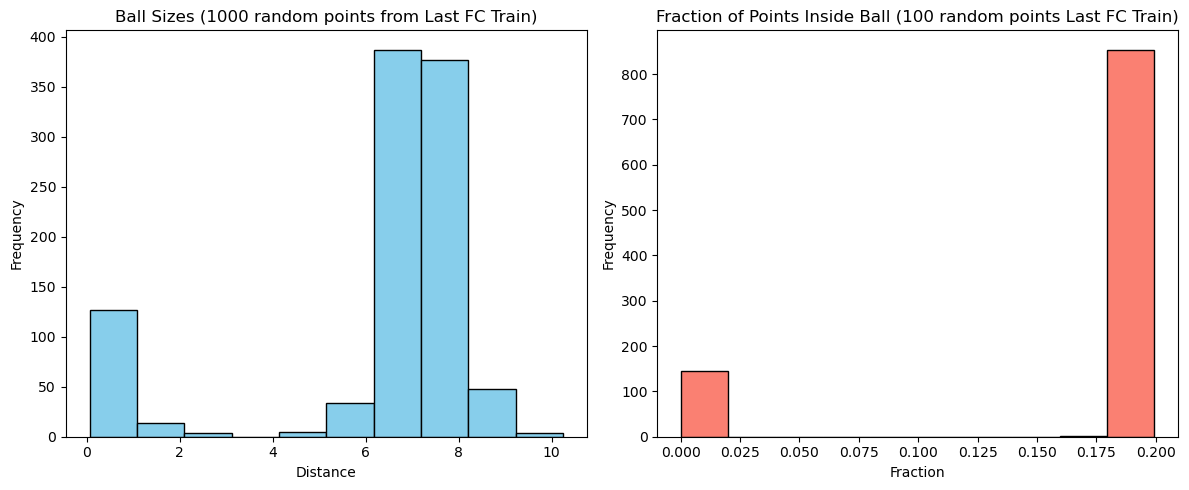

In [34]:
plt.figure(figsize=(12, 5))

# Plot histogram for distance thresholds
plt.subplot(1, 2, 1)
plt.hist(npm_last_fc_train, bins=10, color='skyblue', edgecolor='black')
plt.title('Ball Sizes (1000 random points from Last FC Train)')
plt.xlabel('Distance')
plt.ylabel('Frequency')

# Plot histogram for fractions within threshold
plt.subplot(1, 2, 2)
plt.hist(fraction_within, bins=20, color='salmon', edgecolor='black')
plt.title('Points Inside Ball (100 random points Last FC Train)')
plt.xlabel('Fraction')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [35]:
npm_last_conv_train, fraction_within_conv = calculate_distance_threshold(conv_feats, labels)

Calculating Distance Thresholds: 100%|██████████| 1000/1000 [00:12<00:00, 77.05it/s]


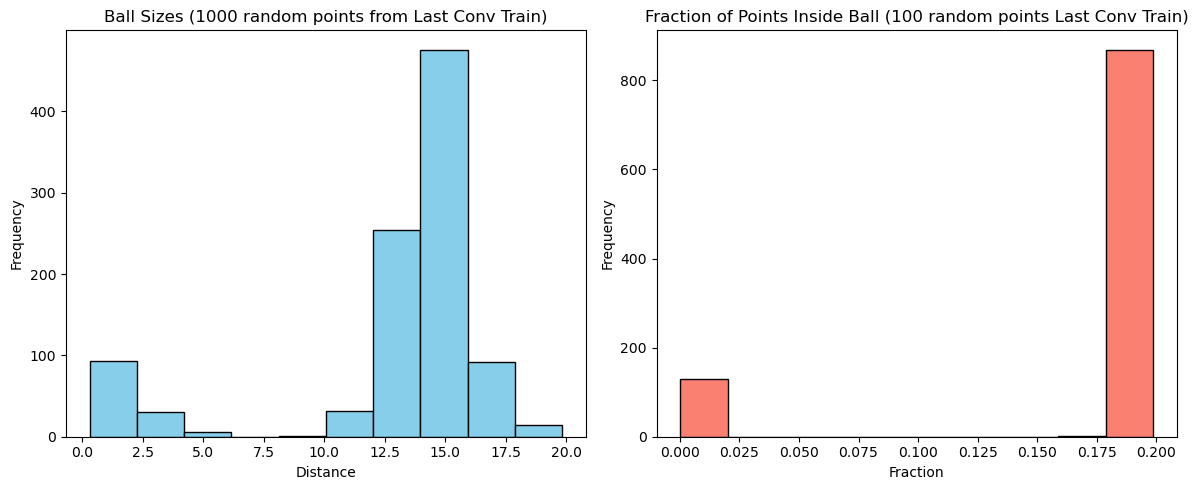

In [36]:
plt.figure(figsize=(12, 5))

# Plot histogram for distance thresholds
plt.subplot(1, 2, 1)
plt.hist(npm_last_conv_train, bins=10, color='skyblue', edgecolor='black')
plt.title('Ball Sizes (1000 random points from Last Conv Train)')
plt.xlabel('Distance')
plt.ylabel('Frequency')

# Plot histogram for fractions within threshold
plt.subplot(1, 2, 2)
plt.hist(fraction_within_conv, bins=10, color='salmon', edgecolor='black')
plt.title('Fraction of Points Inside Ball (100 random points Last Conv Train)')
plt.xlabel('Fraction')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()